In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Lets do some Machine learning

In [2]:
def evaluate_classification_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)

    # Display results
    print(f"Classification Model {model} Evaluation:")
    print("===========================")
    print(f"F1 score: {f1:.2f}")

## read data

In [2]:
train_data = np.genfromtxt('../knock-down-detection/data/train.csv', delimiter=';')
val_data = np.genfromtxt('../knock-down-detection/data/val.csv', delimiter=';')
test_data = np.genfromtxt('../knock-down-detection/data/test.csv', delimiter=';')

In [3]:
X_train = train_data[:,:-1]
y_train = train_data[:,-1].astype(int)
X_val = val_data[:,:-1]
y_val = val_data[:,-1].astype(int)
X_test = test_data[:,:-1]
y_test = test_data[:,-1].astype(int)

In [13]:
mask = np.isnan(X_train)
total_missing = np.sum(mask)

print(f"Amount of NaNs: {total_missing}")

Amount of NaNs: 0


In [4]:
df = pd.DataFrame(X_train)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)


In [5]:
n_components = 2
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(normalized_data)

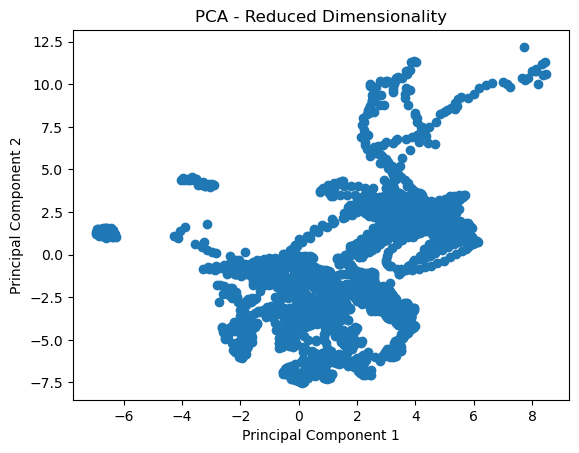

In [6]:
reduced_df = pd.DataFrame(data=reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Wykres punktowy
plt.scatter(reduced_df['PC1'], reduced_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Reduced Dimensionality')
plt.show()

Determine few clssification models

In [5]:
svc = SVC()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
gnb = GaussianNB()

In [6]:
scaler = StandardScaler()

In [11]:
svc_pipe = Pipeline([
    ('scaler', scaler),
    ('model', svc),
    ])
rfc_pipe = Pipeline([
    ('scaler', scaler),
    ('model', rfc),
    ])
gbc_pipe = Pipeline([
    ('scaler', scaler),
    ('model', gbc),
    ])
abc_pipe = Pipeline([
    ('scaler', scaler),
    ('model', abc),
    ])
gnb_pipe = Pipeline([
    ('scaler', scaler),
    ('model', gnb),
    ])


In [12]:
svc_pipe.fit(X_train, y_train).score(X_val, y_val)
rfc_pipe.fit(X_train, y_train).score(X_val, y_val)
gbc_pipe.fit(X_train, y_train).score(X_val, y_val)
abc_pipe.fit(X_train, y_train).score(X_val, y_val)
gnb_pipe.fit(X_train, y_train).score(X_val, y_val)

0.9797395079594791

In [13]:
evaluate_classification_model(svc_pipe, X_test, y_test)
evaluate_classification_model(rfc_pipe, X_test, y_test)
evaluate_classification_model(gbc_pipe, X_test, y_test)
evaluate_classification_model(abc_pipe, X_test, y_test)
evaluate_classification_model(gnb_pipe, X_test, y_test)

Classification Model Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())]) Evaluation:
F1 score: 0.61
Classification Model Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())]) Evaluation:
F1 score: 0.79
Classification Model Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier())]) Evaluation:
F1 score: 0.58
Classification Model Pipeline(steps=[('scaler', StandardScaler()), ('model', AdaBoostClassifier())]) Evaluation:
F1 score: 0.61
Classification Model Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianNB())]) Evaluation:
F1 score: 0.62


In [14]:
preds = rfc_pipe.predict(X_test)

In [15]:
preds

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

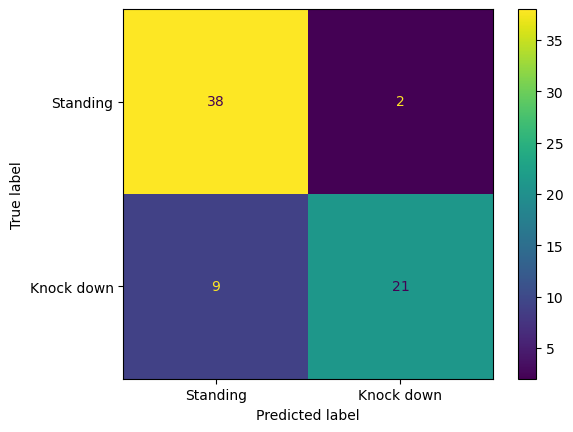

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Standing", "Knock down"])

cm_display.plot()
plt.show()

In [17]:
precision_score(y_test, preds)

0.9130434782608695

In [18]:
recall_score(y_test, preds)

0.7

In [19]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

In [20]:
grid_search = GridSearchCV(rfc_pipe, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200]},
             scoring='f1')

In [21]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [22]:
best_params

{'model__max_depth': 20,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [23]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=50))])

In [24]:
evaluate_classification_model(best_model, X_test, y_test)

Classification Model Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=50))]) Evaluation:
F1 score: 0.92


In [25]:
final_pipe = Pipeline([
    ('scaler', scaler),
    ('model', RandomForestClassifier()),
    ])

In [26]:
final_pipe.set_params(**{key: value for key, value in best_params.items()})

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=50))])

In [27]:
final_pipe.fit(X_train, y_train).score(X_val, y_val)

0.2759286058851905

In [28]:
evaluate_classification_model(final_pipe, X_test, y_test)

Classification Model Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=50))]) Evaluation:
F1 score: 0.92


In [29]:
final_preds = final_pipe.predict(X_test)

In [30]:
precision_score(y_test, final_preds)

0.9310344827586207

In [31]:
recall_score(y_test, final_preds)

0.9

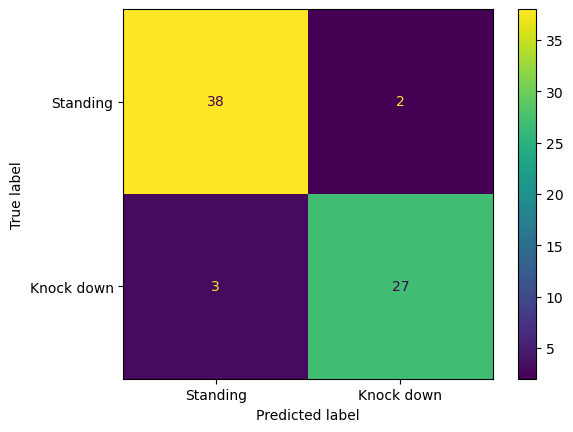

In [32]:
cm = confusion_matrix(y_test, final_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Standing", "Knock down"])

cm_display.plot()
plt.show()

### Clusterization self-check

In [7]:
from sklearn.cluster import KMeans

X = normalized_data  # lub użyj danych przed normalizacją, jeśli nie została wykonana

X_pca = pca.transform(X)


In [8]:

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X_pca)

# Dodaj kolumnę z przypisanymi klastrami do DataFrame
df['Cluster'] = clusters

In [9]:
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters
})

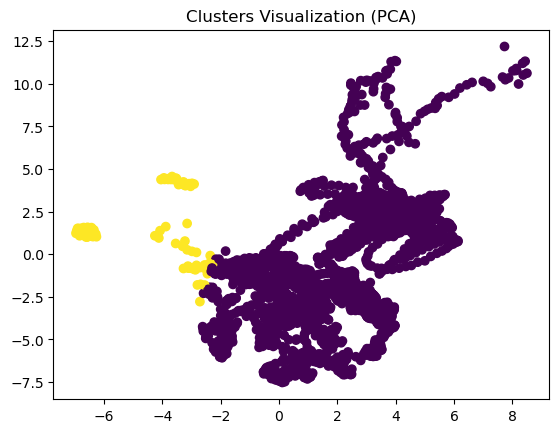

In [10]:
# predicted clusters
plt.scatter(df_plot['PC1'], df_plot['PC2'], c=df_plot['Cluster'], cmap='viridis')
plt.title('Clusters Visualization (PCA)')
plt.show()

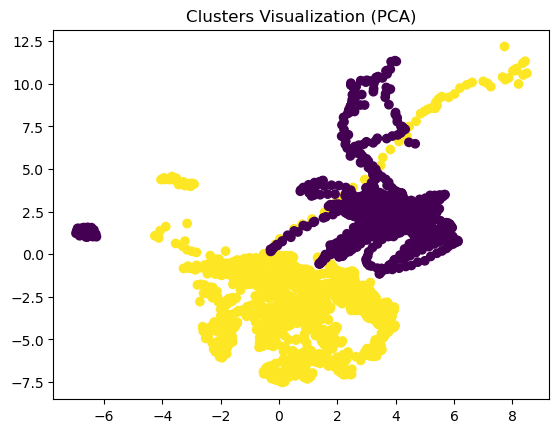

In [14]:
# true clusters
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=y_train.astype(int), cmap='viridis')
plt.title('Clusters Visualization (PCA)')
plt.show()

In [11]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X, y_train)
print(f"Davies–Bouldin Index: {db_score}")
